In [13]:
# 청와대 국민청원 데이터 셋
import os
import urllib.request
import ssl
url = 'https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition_sampled.csv'

# ssl 인증서 무시하는것.
ssl._create_default_https_context = ssl._create_unverified_context

# 데이터 받아오기
urllib.request.urlretrieve(url, './sample.csv')



('./sample.csv', <http.client.HTTPMessage at 0x340307ce0>)

In [14]:
import pandas as pd
df = pd.read_csv("sample.csv") 
df.head()

,article_id,start,end,answered,votes,category,title,content
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...
1,63,2017-08-20,2017-09-04,0,1,보건복지,살려주세요..,안녕하십니까?\n저는 올해 63세된 홀로 사는 늙은 여자입니다...\n작년 중복날 ...
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...
3,141,2017-08-20,2017-08-27,0,0,기타,한국문화에 창조적요소를 심자,안녕하십니까\n저는 92년 한국을 알게된 종국동포 입니다.\n[저는 한 중소기업에...
4,148,2017-08-20,2017-11-18,0,7,외교/통일/국방,다문화정책 및 할랄 인증 제도,대한민국과 국민을 위해 밤낮 없이 수고하시는 대통령을 비롯한 위정자 분들께\n대한민...


In [15]:
df.shape

(18077, 8)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18077 entries, 0 to 18076
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  18077 non-null  int64 
 1   start       18077 non-null  object
 2   end         18077 non-null  object
 3   answered    18077 non-null  int64 
 4   votes       18077 non-null  int64 
 5   category    18077 non-null  object
 6   title       18077 non-null  object
 7   content     18077 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.1+ MB


In [17]:
#한국어 전처리
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
okt = Okt()
#명사만, 한글자 이상만
def tokenizer(doc): 
    return [token for token in okt.nouns(doc) if len(token) > 1 ]

cv = CountVectorizer(max_features=10000, min_df=5, max_df=0.5, tokenizer=tokenizer)
pet_cv = cv.fit_transform(df.content)
print(f'countervectorizer 형태 : {pet_cv.shape}')

/Users/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


countervectorizer 형태 : (18077, 10000)


In [18]:
# LDA 모델 학습
from sklearn.decomposition import LatentDirichletAllocation
import time

#시간측정
start_time = time.time()
lda = LatentDirichletAllocation(n_components=len(df.category.unique()),
                        n_jobs=-1,
                        random_state=45
                        )
pet_topics = lda.fit_transform(pet_cv)
elapsed_time = time.time() - start_time
print(f'lda 학습시간 : {elapsed_time:.2f}초')

lda 학습시간 : 7.27초


In [19]:
# 토픽단어 출력함수
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}: ", end='')
        top_indices = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(", ".join(top_words))
feature_names = cv.get_feature_names_out()
print_top_words(lda, feature_names,15)       

Topic #0: 북한, 우리, 한국, 선수, 대통령, 대한민국, 미국, 일본, 국민, 생각, 정부, 문재인, 남북, 나라, 중국
Topic #1: 사람, 동물, 소음, 생각, 문제, 쓰레기, 때문, 환경, 생명, 강아지, 우리, 인간, 제발, 항공기, 아파트
Topic #2: 연금, 정부, 국민연금, 화폐, 기업, 투자, 가상, 경제, 국민, 공무원, 시장, 국가, 거래, 기술, 생각
Topic #3: 국민, 여성, 사회, 생각, 남성, 국가, 대통령, 의무, 대한민국, 사람, 군대, 대한, 헌법, 나라, 남자
Topic #4: 경찰, 범죄, 국민, 위해, 무고, 불법, 대한민국, 사건, 범죄자, 만행, 조직, 부정부패, 증거, 사리, 살인마
Topic #5: 사건, 처벌, 피해자, 사람, 생각, 가해자, 병원, 피해, 범죄, 폭행, 보호, 가족, 검사, 대한, 사고
Topic #6: 회사, 이명박, 청원, 게임, 개인, 댓글, 삼성, 협회, 운영, 대한, 사이트, 출국금지, 위원회, 회장, 업체
Topic #7: 정부, 부동산, 지역, 주택, 서울, 국민, 정책, 아파트, 투기, 집값, 지방, 강남, 건설, 국가, 제도
Topic #8: 공무원, 불법, 방송, 조직, 행정, 사찰, 국민, 사람, 이용, 감시, 방법, 정보, 인터넷, 때문, 유공
Topic #9: 근무, 시간, 생각, 차량, 근로자, 장애인, 채용, 경우, 회사, 사고, 택시, 임금, 개선, 고용, 사람
Topic #10: 관리, 공사, 주민, 저희, 시설, 사업, 건물, 사용, 직원, 설치, 허가, 현장, 문제, 안전, 업무
Topic #11: 국민, 나라, 대통령, 사람, 생각, 지금, 정부, 청원, 우리, 대한민국, 세금, 정책, 난민, 문재인, 국가
Topic #12: 내용, 담배, 전화, 흡연, 민원, 조사, 확인, 처리, 본인, 답변, 호텔, 사실, 행사, 번호, 청원
Topic #13: 학생, 아이, 학교, 생각, 교육, 문제, 대학, 선생님, 교사, 사회, 공부, 사람, 시험,

In [ ]:
# 토픽 트랜드 분석
#  *** 시간 정보 추출 ***
df['period'] = pd.to_datetime(df['start']).dt.strftime('%Y-%m')
# 토픽 데이터 프레임 - 실제 토픽 수에 맞게 조정
topic_columns = [f'Topic{i+1}' for i in range(17)]  # 17개 토픽으로 수정
trend_data = pd.DataFrame(pet_topics, columns=topic_columns)
trend_data['period'] = df['period'].values
trend_data.head(3)

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,period
0,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,0.300204,0.000182,0.000182,0.000182,0.216562,0.000182,0.230548,0.000182,0.085179,0.000182,0.165328,2017-08
1,0.000456,0.049953,0.064299,0.000456,0.000456,0.052643,0.000456,0.000456,0.069490,0.000456,0.000456,0.054181,0.130132,0.000456,0.000456,0.284237,0.290962,2017-08
2,0.000865,0.000865,0.000865,0.000865,0.000865,0.000865,0.000865,0.000865,0.000865,0.000865,0.000865,0.000865,0.000865,0.986159,0.000865,0.000865,0.000865,2017-08


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/1l/rpxsxc3j1b15kw96kqt86gh80000gn/T/ipykernel_50031/2769


기간별 토픽 분포:
           Topic1    Topic2    Topic3    Topic4    Topic5    Topic6    Topic7  \
period                                                                          
2017-08  0.042326  0.018395  0.033822  0.051560  0.011512  0.065308  0.035222   
2017-09  0.040809  0.020681  0.020770  0.049754  0.024319  0.279226  0.021020   
2017-10  0.055775  0.050389  0.038392  0.094778  0.051586  0.109777  0.038897   
2017-11  0.034536  0.037698  0.022112  0.057945  0.036609  0.106991  0.234057   
2017-12  0.046346  0.041166  0.046753  0.073619  0.025878  0.088059  0.045980   

           Topic8    Topic9   Topic10   Topic11   Topic12   Topic13   Topic14  \
period                                                                          
2017-08  0.025517  0.014808  0.094635  0.070575  0.080083  0.039218  0.138540   
2017-09  0.018660  0.014345  0.039947  0.031565  0.073422  0.049305  0.148889   
2017-10  0.029847  0.034628  0.093971  0.051046  0.077974  0.045576  0.112531   
2017-11  0.0239

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

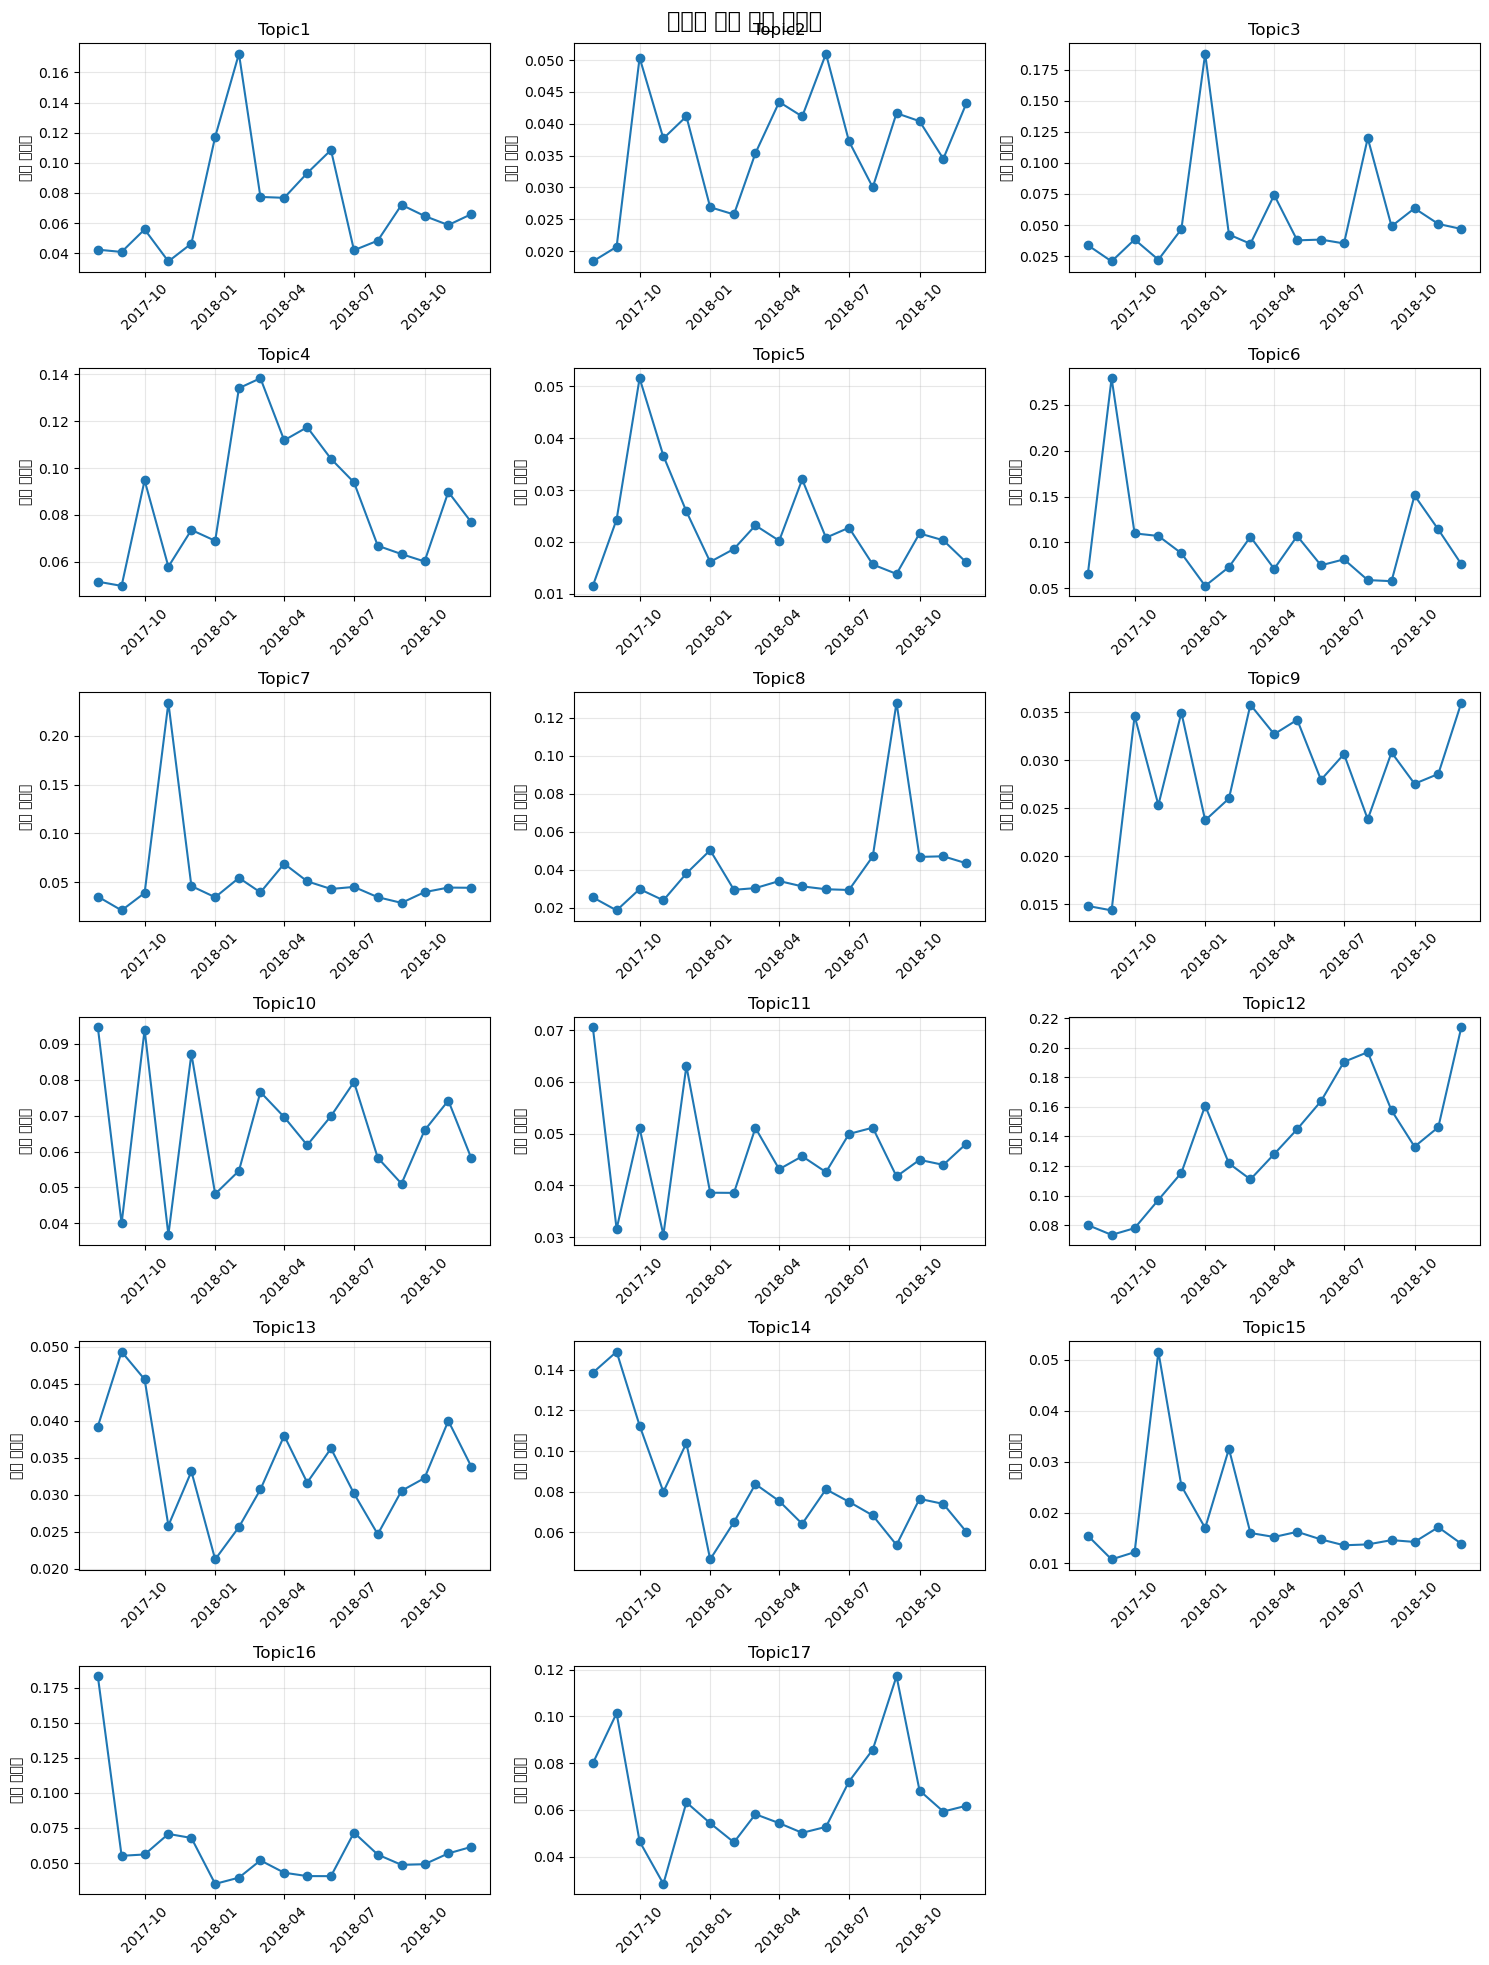

Exception ignored in: <function ResourceTracker.__del__ at 0x104ed1c60>
Traceback (most recent call last):
  File "/Users/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105185c60>
Traceback (most recent call last):
  File "/Users/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107611c60>
Traceback (most rece

In [ ]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 기간별 평균 토픽 가중치 계산
trend = trend_data.groupby('period').mean()

print("\n기간별 토픽 분포:")
print(trend.head())

# 시간 트렌드 시각화
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 6x3 그리드로 변경하여 17개 토픽 표시
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
fig.suptitle('시간에 따른 토픽 트렌드', fontsize=16)

# x축을 datetime으로 변환
trend.index = pd.to_datetime(trend.index)
trend_sorted = trend.sort_index()

for idx, (ax, topic) in enumerate(zip(axes.flat[:17], topic_columns)):  # 17개 토픽만 순회
    ax.plot(trend_sorted.index, trend_sorted[topic], marker='o')
    ax.set_title(topic)
    ax.set_ylabel('평균 가중치')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)

# 남은 subplot 제거
for ax in axes.flat[17:]:
    ax.remove()

plt.tight_layout()
plt.show()

In [1]:
df.category.unique()

NameError: name 'df' is not defined

In [ ]:
print_top_words(lda, feature_names,15)